In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
from platform import python_version
print(python_version())

3.6.8


In [4]:
import torch
from src.aggregator import *
from src.datagen.sinecurve import *
from src.datagen.gpcurve import *

## GP tester

- RBF
- Matern
- Additive
- Product

In [5]:
gpgen = RBFGPCurvesReader(16, 100)

In [6]:
a = gpgen.generate_curves()

In [7]:
import matplotlib.pyplot as plt

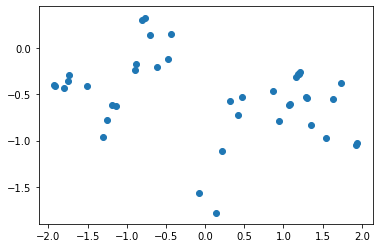

In [8]:
plt.scatter(a[0][0][0][0], a[0][0][1][0])

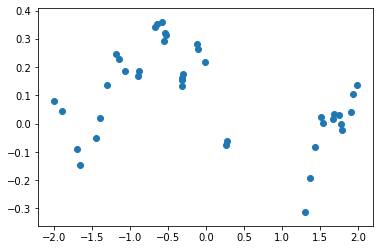

In [9]:
plt.scatter(a[0][0][0][1], a[0][0][1][1])

In [10]:
materngp = MaternGPCurvesReader(16,100)

In [11]:
a = gpgen.generate_curves()

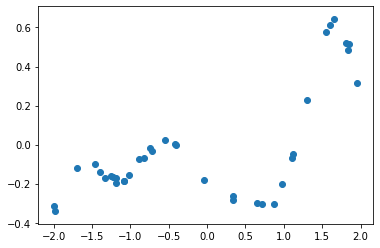

In [12]:
plt.scatter(a[0][0][0][0], a[0][0][1][0])

## Sine curve tester


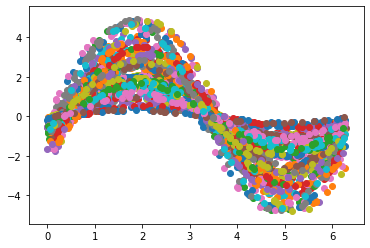

In [13]:
this = SineCurvesReader().generate_curves()
context_data_x, context_data_y = this.query[0]
context_data_x = context_data_x.squeeze()
context_data_y = context_data_y.squeeze()

context_data_x.shape
context_data_y.shape

for curve_id in range(context_data_x.shape[0]):
    plt.scatter(context_data_x[curve_id, :].tolist(), context_data_y[curve_id, :].tolist())

## Encoder

In [14]:
from src.decoder import *
from src.encoder import *
from src.utils import *

## Decoder

## Attentive Neural Process

In [15]:
from src.neural_process import *

## Training

In [16]:
TRAINING_ITERATIONS = 100000 #@param {type:"number"}
MAX_CONTEXT_POINTS = 50 #@param {type:"number"}
PLOT_AFTER = 10000 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}
ATTENTION_TYPE = 'uniform' #@param ['uniform','laplace','dot_product','multihead']
random_kernel_parameters=True #@param {type:"boolean"}

In [17]:
# Train dataset
dataset_train = RBFGPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)
data_train = dataset_train.generate_curves()

# Test dataset
dataset_test = RBFGPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True, random_kernel_parameters=random_kernel_parameters)
data_test = dataset_test.generate_curves()



In [18]:
#query = ((context_x, context_y), target_x)

In [19]:
data_train.query[0][0].shape

torch.Size([16, 36, 1])

In [20]:
data_train.query[0][1].shape

torch.Size([16, 36, 1])

In [21]:
data_train.query[1][0].shape

torch.Size([40, 1])

In [22]:
data_train.target_y.shape

torch.Size([16, 40, 1])

In [23]:
# Sizes of the layers of the MLPs for the encoders and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
latent_encoder_output_sizes = HIDDEN_SIZE
num_latents = HIDDEN_SIZE
deterministic_encoder_output_sizes= HIDDEN_SIZE*4
decoder_output_sizes = HIDDEN_SIZE*2 + 2
use_deterministic_path = True

In [24]:
detencoder = DeterministicEncoder(1, 1, deterministic_encoder_output_sizes)
latencoder = LatentEncoder(1, 1, num_latents)
decoder = HeteroskedasticDecoder(1, num_latents, 1, decoder_output_sizes, 3)
att = Attention('mlp','multihead', 1, deterministic_encoder_output_sizes)
anp = AttentiveNeuralProcess(detencoder, att, latencoder, decoder, True)

In [25]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(anp.parameters(), lr=0.001, momentum=0.9)
EPOCHS = 5


In [26]:
for epoch in range(EPOCHS):
    epoch_loss = 0
    # Train dataset
    dataset_train = RBFGPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)
    data_train = dataset_train.generate_curves()
    x_context = data_train.query[0][0]
    y_context = data_train.query[0][1]
    x_target = data_train.query[1]
    y_target = data_train.target_y
    
    optimizer.zero_grad()
    
    y_target_mu, y_target_sigma, log_pred, kl_target_context, loss = anp.forward(x_context, y_context, x_target, y_target)
    loss.backward()
    optimizer.step()
    

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [27]:
batch_size, num_context_points, y_size = y_context.size()
_, num_target_points, _ = x_target.size()

# map the context points to their deterministic represnetations.
# r_i : Shape (batch_size, num_context_points, r_dim)
r_i = anp.deterministic_encoder(x_context, y_context)

In [28]:
r_i.shape

torch.Size([16, 27, 512])

In [29]:
r_j = anp.attention(x_target, x_context, r_i)

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [31]:
anp

AttentiveNeuralProcess(
  (deterministic_encoder): DeterministicEncoder(
    (encoder): BatchMLP(
      (activation): ReLU()
      (model): Sequential(
        (0): Linear(in_features=2, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): ReLU()
        (6): Linear(in_features=50, out_features=512, bias=True)
      )
    )
  )
  (attention): Attention(
    (batch_mlp): BatchMLP(
      (activation): ReLU()
      (model): Sequential(
        (0): Linear(in_features=1, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (multihead_attention): MultiheadAttention(
      (out_proj): Linear